# API Pull (Sean)

In [58]:
# Dependencies

import pandas as pd
import requests
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import datetime


# Import the OpenWeatherMap API key

from config import api_key


In [59]:
# Define parameters

lat = 41.9
lon = -87.6

# Set the API base URL

url = f'https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&units=metric&appid={api_key}'

# Request and get the API

chicago_current_weather = requests.get(url).json()

# Current Time in chicago
utc_now = datetime.datetime.now()
chicago_time = utc_now + datetime.timedelta(hours=-6)

chicago_current_weather

{'lat': 41.9,
 'lon': -87.6,
 'timezone': 'America/Chicago',
 'timezone_offset': -21600,
 'current': {'dt': 1733976824,
  'sunrise': 1733922515,
  'sunset': 1733955568,
  'temp': -9.73,
  'feels_like': -16.73,
  'pressure': 1020,
  'humidity': 57,
  'dew_point': -15.92,
  'uvi': 0,
  'clouds': 20,
  'visibility': 10000,
  'wind_speed': 8.75,
  'wind_deg': 280,
  'wind_gust': 16.98,
  'weather': [{'id': 801,
    'main': 'Clouds',
    'description': 'few clouds',
    'icon': '02n'}]},
 'minutely': [{'dt': 1733976840, 'precipitation': 0},
  {'dt': 1733976900, 'precipitation': 0},
  {'dt': 1733976960, 'precipitation': 0},
  {'dt': 1733977020, 'precipitation': 0},
  {'dt': 1733977080, 'precipitation': 0},
  {'dt': 1733977140, 'precipitation': 0},
  {'dt': 1733977200, 'precipitation': 0},
  {'dt': 1733977260, 'precipitation': 0},
  {'dt': 1733977320, 'precipitation': 0},
  {'dt': 1733977380, 'precipitation': 0},
  {'dt': 1733977440, 'precipitation': 0},
  {'dt': 1733977500, 'precipitation': 

In [60]:
# Load the bikeshare dataset (replace with your actual file path)

data = pd.read_csv('../output/merged_weather_bike_data.csv')

# Metrics to Predict data by

data = data[['temp', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust', 'ride_id']]

# Count rides grouped by weather-related features

base_data = data.groupby(['temp', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'wind_gust'], as_index=False)['ride_id'].count()
base_data.rename(columns={'ride_id': 'ride_count'}, inplace=True)

base_data

,temp,feels_like,pressure,humidity,wind_speed,wind_deg,wind_gust,ride_count
0,-22.86,-29.86,1013,75,12.07,281,16.54,3
1,-22.48,-29.48,1013,75,12.52,282,15.20,2
2,-22.36,-29.36,1013,76,14.31,282,17.88,6
3,-22.31,-29.31,1013,76,15.20,280,17.88,7
4,-21.84,-28.84,1013,75,11.18,273,17.43,5
...,...,...,...,...,...,...,...,...
20222,37.34,44.34,1010,49,6.69,250,11.32,1344
20223,37.47,44.47,1007,51,8.23,240,11.83,1206
20224,38.05,45.05,1008,47,6.69,220,11.32,510
20225,38.13,45.13,1011,46,3.58,295,5.81,916


In [61]:
# Load the bikeshare weather dataset
data = pd.read_csv('../output/merged_weather_bike_data.csv')

# Convert and extract month from Weather API JSON dt and limit applicable data to the same month
applicable_month = pd.to_datetime(chicago_current_weather['hourly'][0]['dt'], unit='s').month
applicable_data = data.loc[data['start_month'] == applicable_month, :]

# Metrics to Predict data by
applicable_data = applicable_data[['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'ride_id']]

# Count rides grouped by weather-related features
base_data = applicable_data.groupby(
    ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity'], as_index=False)['ride_id'].count()
base_data.rename(columns={'ride_id': 'ride_count'}, inplace=True)

# Define sampled columns and results list
sampled_columns = ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity']
predicted_metrics = []

# Loop through the hourly weather data
for hour in chicago_current_weather['hourly']:
    # Define the datetime in question
    dt = pd.to_datetime(hour['dt'], unit='s')

    # Loop through each metric and predict bikeshare usage
    for metric in sampled_columns:
        # Prepare training data
        X = base_data[[metric]]
        y = base_data['ride_count']

        # Train a simple regression model using linregress
        slope, intercept, r_value, p_value, std_err = linregress(X[metric], y)

        # Calculate R-squared
        r_squared = r_value ** 2

        # Predict ride count using linregress formula (y = mx + b)
        predicted_ride_count = slope * hour.get(metric, 0) + intercept

        # Add prediction and R-squared value to results
        predicted_metrics.append({
            'Datetime': dt,
            'Metric': metric,
            'Value': max(0, int(predicted_ride_count)),
            'R_squared': round(r_squared, 4)  # Round R-squared for readability
        })

# Convert the list of dictionaries into a DataFrame
predicted_ride_df = pd.DataFrame(predicted_metrics)

# Display the updated DataFrame
predicted_ride_df

,Datetime,Metric,Value,R_squared
0,2024-12-12 04:00:00,temp,34,0.1506
1,2024-12-12 04:00:00,feels_like,34,0.1501
2,2024-12-12 04:00:00,temp_min,114,0.1577
3,2024-12-12 04:00:00,temp_max,103,0.1469
4,2024-12-12 04:00:00,pressure,119,0.0013
...,...,...,...,...
283,2024-12-14 03:00:00,feels_like,104,0.1501
284,2024-12-14 03:00:00,temp_min,114,0.1577
285,2024-12-14 03:00:00,temp_max,103,0.1469
286,2024-12-14 03:00:00,pressure,128,0.0013


In [65]:
# A prediction data series by the hour with R^2 values

prediction_series = predicted_ride_df.groupby("Datetime").agg({"Value": "mean", "R_squared": "mean"}).reset_index().rename(columns={"Value": "Predicted Ride Count", "R_squared": "Mean R_squared"})

# Metrics-by-the-hour table with R^2 values
metrics_table_values = predicted_ride_df.pivot(index="Datetime", columns="Metric", values="Value").reset_index()
metrics_table_r_squared = predicted_ride_df.pivot(index="Datetime", columns="Metric", values="R_squared").reset_index()

# Merge value and R^2 tables, adding suffixes for clarity
metrics_table = metrics_table_values.merge(
    metrics_table_r_squared,
    on="Datetime",
    suffixes=("_Value", "_R_squared")
)

# Ensure Predicted Ride Count is an integer
prediction_series["Predicted Ride Count"] = prediction_series["Predicted Ride Count"].astype(int)

# Display the updated tables
print("Clean Representative Ride Count Table with R-squared:")
display(prediction_series.head())
display(prediction_series.tail())

print("Metrics-by-Time Table with R-squared:")
display(metrics_table.head())
display(metrics_table.tail())


Clean Representative Ride Count Table with R-squared:


,Datetime,Predicted Ride Count,Mean R_squared
0,2024-12-12 04:00:00,93,0.111717
1,2024-12-12 05:00:00,95,0.111717
2,2024-12-12 06:00:00,96,0.111717
3,2024-12-12 07:00:00,97,0.111717
4,2024-12-12 08:00:00,96,0.111717


,Datetime,Predicted Ride Count,Mean R_squared
43,2024-12-13 23:00:00,122,0.111717
44,2024-12-14 00:00:00,122,0.111717
45,2024-12-14 01:00:00,120,0.111717
46,2024-12-14 02:00:00,117,0.111717
47,2024-12-14 03:00:00,116,0.111717


Metrics-by-Time Table with R-squared:


Metric,Datetime,feels_like_Value,humidity_Value,pressure_Value,temp_Value,temp_max_Value,temp_min_Value,feels_like_R_squared,humidity_R_squared,pressure_R_squared,temp_R_squared,temp_max_R_squared,temp_min_R_squared
0,2024-12-12 04:00:00,34,157,119,34,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
1,2024-12-12 05:00:00,35,167,119,35,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
2,2024-12-12 06:00:00,34,174,120,34,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
3,2024-12-12 07:00:00,31,184,121,30,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
4,2024-12-12 08:00:00,27,191,121,25,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577


Metric,Datetime,feels_like_Value,humidity_Value,pressure_Value,temp_Value,temp_max_Value,temp_min_Value,feels_like_R_squared,humidity_R_squared,pressure_R_squared,temp_R_squared,temp_max_R_squared,temp_min_R_squared
43,2024-12-13 23:00:00,104,181,128,106,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
44,2024-12-14 00:00:00,104,177,128,107,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
45,2024-12-14 01:00:00,103,167,128,107,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
46,2024-12-14 02:00:00,103,152,128,107,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577
47,2024-12-14 03:00:00,104,142,128,107,103,114,0.1501,0.0637,0.0013,0.1506,0.1469,0.1577


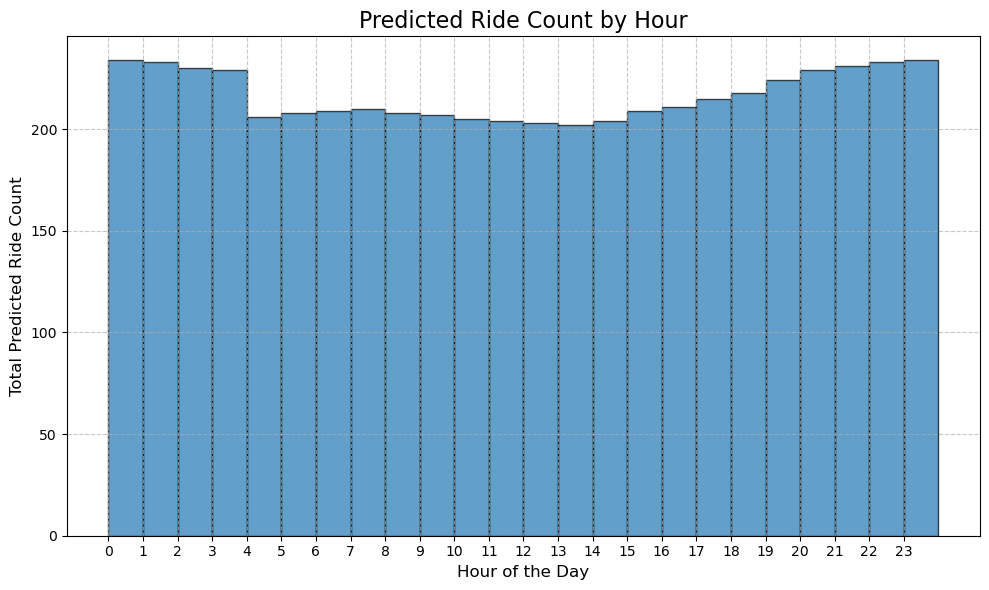

In [63]:
# Extract hour from datetime for histogram
prediction_series["Hour"] = prediction_series["Datetime"].dt.hour

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(prediction_series["Hour"], bins=range(0, 25), weights=prediction_series["Predicted Ride Count"], edgecolor="black", alpha=0.7)

# Add titles and labels
plt.title("Predicted Ride Count by Hour", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Total Predicted Ride Count", fontsize=12)
plt.xticks(range(0, 24, 1))
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

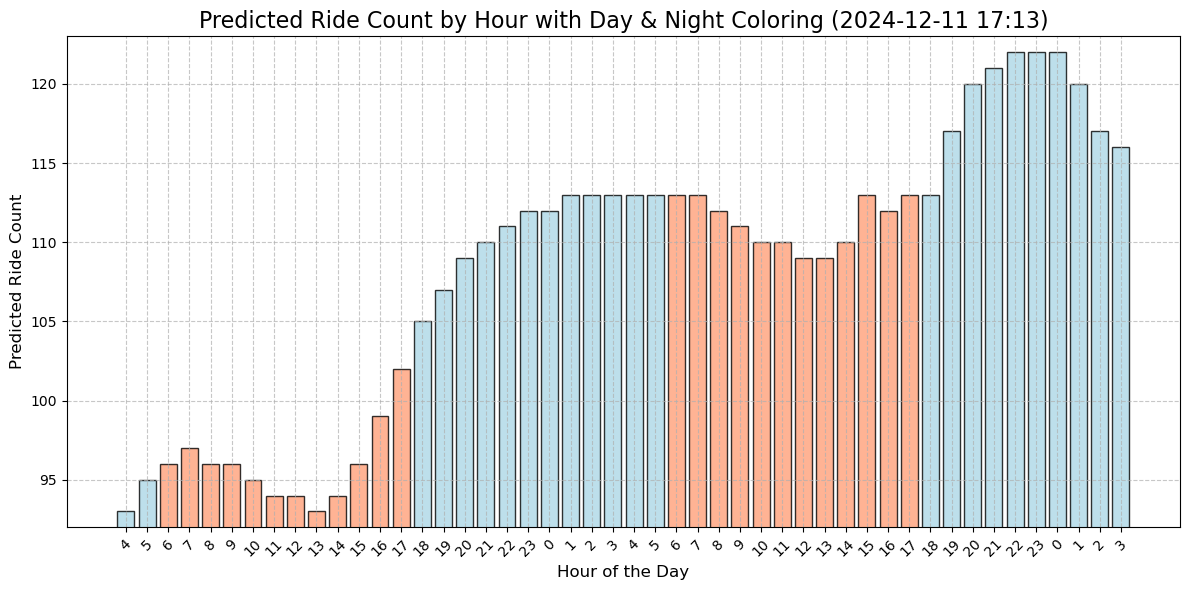

In [64]:
# Extract the start hour from the forecasted data
start_hour = prediction_series["Datetime"].iloc[0].hour

# Assign sequential hours using the index instead of iteration
prediction_series["Hour"] = (start_hour + prediction_series.index) % 24

# Assign colors based on day or night
colors = ["lightsalmon" if hour in range(6, 18) else "lightblue" for hour in prediction_series["Hour"]]

# Plot the histogram with corrected hours as the x-axis
plt.figure(figsize=(12, 6))
bars = plt.bar(
    range(len(prediction_series)), 
    prediction_series["Predicted Ride Count"], 
    color=colors, 
    edgecolor="black", 
    alpha=0.8
)

# Add titles and labels
plt.title(f"Predicted Ride Count by Hour with Day & Night Coloring ({chicago_time.strftime('%Y-%m-%d %H:%M')})", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Predicted Ride Count", fontsize=12)

# Set x-ticks to match the actual hours of the day
plt.xticks(
    ticks=range(len(prediction_series)), 
    labels=prediction_series["Hour"], 
    rotation=45  # Rotate labels for better readability
)

# Set the y-axis limit to start one unit below the lowest value
plt.ylim(prediction_series["Predicted Ride Count"].min() - 1, prediction_series["Predicted Ride Count"].max() + 1)

# Set Grid
plt.grid(visible=True, linestyle="--", alpha=0.7)

# Show the plot and save the fig
plt.tight_layout()
plt.savefig('../output/Predicted Ride Count by Hour with Day & Night Coloring')
plt.show()
